In [5]:
import sys
from pathlib import Path

# Add project root to PYTHONPATH
project_root = Path.cwd().parent  # or Path("/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition")
sys.path.append(str(project_root))

# Confirm it's added
print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
import lightning as L

# You might need to update these paths to your project structure
from ffnn.nn_classifier import NNClassifier
from ffnn.hparams_tune import prepare_data

n_features_select = 200
checkpoint_path = "/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition/checkpoints/trial_36_best.ckpt"


In [7]:
# Load the best model from checkpoint
best_model = NNClassifier.load_from_checkpoint(
    checkpoint_path,
    input_dim=n_features_select
)

In [8]:
# Prepare the test data
_, _, test_loader, _, _, label_encoder = prepare_data(n_features_select)

trainer = L.Trainer(
    accelerator="mps" if torch.backends.mps.is_available() else "auto"
)

# Run the test method (will print test accuracy if defined in the model)
trainer.test(best_model, test_loader)


/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition/data/feature_extraction/preprocess_features.py:15: ParserWarning: Skipping line 4: expected 6375 fields, saw 6376
Skipping line 43: expected 6375 fields, saw 6376

  df = pd.read_csv(f'{base_path}/features/combined_features.csv', on_bad_lines='warn')
/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition/data/feature_extraction/preprocess_features.py:15: ParserWarning: Skipping line 150: expected 6375 fields, saw 6376
Skipping line 177: expected 6375 fields, saw 6376

  df = pd.read_csv(f'{base_path}/features/combined_features.csv', on_bad_lines='warn')
/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition/data/feature_extraction/preprocess_features.py:15: ParserWarning: Skipping line 408: expected 6375 fields, saw 6376
Skipping line 421: expected 6375 fields, saw 6376
Skipping line 422: expected 6375 fields, saw 6376

  df = pd.read_csv(f'{base_path}/features/combined_features.csv', on_bad_lines='warn')
/U

Features shape: (43566, 6374)
Target shape: (43566,)
Input shape before PCA: (43566, 6374)
Selecting 200 features
val
Input shape before PCA: (9337, 6374)
test
Input shape before PCA: (9332, 6374)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/joel-tay/Desktop/AI-Project--Speech-Emotion-Recognition/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_da

Testing DataLoader 0: 100%|██████████| 292/292 [00:01<00:00, 290.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6985640525817871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6985640525817871}]

In [9]:
# Manual loop to collect predictions for classification report & confusion matrix
best_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        logits = best_model(x.to(best_model.device))
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [10]:
# Decode numeric labels to class names
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)


In [11]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))


Classification Report:
              precision    recall  f1-score   support

       Anger       0.71      0.76      0.73       891
       Bored       0.74      0.85      0.79      1098
     Disgust       0.45      0.63      0.53       273
        Fear       0.45      0.64      0.53       285
       Happy       0.75      0.59      0.66      1885
     Neutral       0.69      0.60      0.65      2203
    Question       0.80      0.82      0.81      1139
         Sad       0.68      0.74      0.71       830
    Surprise       0.67      0.76      0.71       728

    accuracy                           0.70      9332
   macro avg       0.66      0.71      0.68      9332
weighted avg       0.71      0.70      0.70      9332



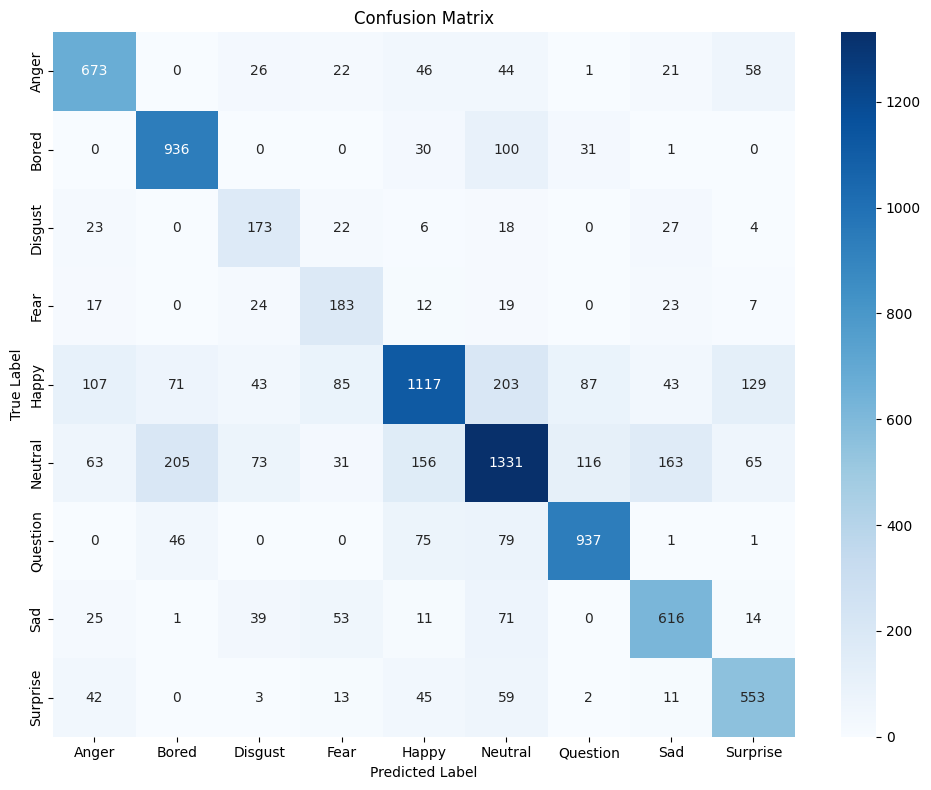

In [12]:
# Plot the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
